<h1>A Simple Model of a ballon in a fluid of Uniform Density</h1>
<h2>Thomas M. Boudreaux</h2>

<h3>Introduction</h3>
Here I present two simple models of a balloon in a confined space. In the first the balloon is acted upon by gravity and a buoyant force. Additionally, there is an effective infintite in magnitude and infintesimal in time normal force applied to the ballon at the boundaries of some user defined volume. The volume containes two fluids, each with a different (but uniform) density. The second model is simialar to the first; however, it may contain much more complex density perturbations throughout, and an additional "wind" force is included in all three spacial dimensions. This model demonstrates how density perturbations may be used as approximations of soft constraint boundaries. 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mplEasyAnimate import animation
from tqdm import tqdm
import time
import integrators as intgs
from helper import display_video, make_animation
from IPython.display import HTML

plt.rc('text', usetex = True)
plt.rc('font', family='serif')

In [2]:
g = 9.8 # m s^-2

<h3>Balloon & Helper Objects</h3>
Here I define a balloon class which will store the ballons position and velocity. This object will also loose energy when reflected off of a boundary. The function
$$
    c_{r}(P) = -40e^{-4.5P} + 0.86
$$
empirically determined <a href=http://isjos.org/JoP/vol3iss2/Papers/JoPv3i2-2COR.pdf>here</a>, is used to calculate the coefficient of restitution for the balloon in one atmosphere of pressure. At a boundary with axis $i$ the new velocity along axis $i$ is then given as
$$
    v_{i, f} = -c_{r}(P) \cdot v_{i, 0}
$$

In [3]:
class balloonObj:
    def __init__(self, radius, rho=0.164, r0=[0, 0, 0], v0=[0, 0, 0], a1=1, a2=1, a3=1):
        self.radius = radius
        self.rho = rho # kg m^-3
        self.volume = ((4/3)*np.pi*self.radius**3)/1000 # m^3
        self.ppos = None
        self.pos = r0 # m
        self.mass = self.volume*self.rho # kg
        self.velocity = v0
        P = 1 #atm
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.cr = -40*np.exp(-4.5*P)+0.86 #http://isjos.org/JoP/vol3iss2/Papers/JoPv3i2-2COR.pdf
    
    def reflect(self, axis):
        self.velocity[axis] = -self.cr * self.velocity[axis] 

Next we define a "helper object" -- confinment -- which simply is used to store the bounds of the rectangular cuboid the balloon is confined within. This confinment object is responsible for reporting if a collision has happened, and what axis that collison is along.

In [4]:
class confinment:
    def __init__(self, bounds):
        # [[xmin, xmax], [ymin, ymax], [zmin, zmax]]
        self.bounds = bounds
        
    def check_x(self, x):
        if self.bounds[0][0] < x < self.bounds[0][1]:
            return False
        else:
            return True
        
    def check_y(self, y):
        if self.bounds[1][0] < y < self.bounds[1][1]:
            return False
        
        else:
            return True
    
    def check_z(self, z):
        if self.bounds[2][0] < z < self.bounds[2][1]:
            return False
        else:
            return True
    
    def check_for_collision(self, pos):
        if self.check_x(pos[0]) and self.check_y(pos[1]) and self.check_z(pos[2]):
            return True
        else:
            return False

Finally we define an object to coordinate the integration. The "worldIntegrator" takes some model, some balloon, some confiner, and an integration scheme to use. It will then allow the user to step the system through time.

In [5]:
class wordIntegrator:
    def __init__(self, confiner, obj, model, method=intgs.rk4, upper_density=1.18, lower_density=1.18):
        self.object = obj
        self.method = method
        self.model = model
        self.confiner = confiner
        self.clock = 0
        self.step = 0   
        self.upper_density = upper_density
        self.lower_density = lower_density
        
    def get_rho(self, ypos):
        if ypos <= self.confiner.bounds[1][1]/2:
            return self.lower_density # kg m^-3
        else:
            return self.upper_density # kg m^-3
        
    def get_args(self):
        args = dict()
        args['m'] = self.object.mass
        args['V'] = self.object.volume
        args['a1'] = self.object.a1
        args['a2'] = self.object.a2
        args['a3'] = self.object.a3
        args['rho_air'] = self.get_rho(self.object.pos[1])
        return args

    def timeEvolve(self, dt):
        """
            Desc: 
                Incriment system by time step dt
        """
        cx = self.confiner.check_x(self.object.pos[0])
        cy = self.confiner.check_y(self.object.pos[1])
        cz = self.confiner.check_z(self.object.pos[2])
        if cx:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(0)
        if cy:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(1)
        if cz:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(2)
            
        cI = list(self.object.pos) + list(self.object.velocity)
        nI = self.method(self.model, cI, self.clock, dt, self.get_args())
        self.object.ppos = self.object.pos
        self.object.pos = nI[:3]
        self.object.velocity = nI[3:]
        
        self.step += 1
        self.clock += dt

<h3>Model</h3>
We develop a three--dimensional model to describe the system, the model is given as
$$
    \frac{dx}{dt} = v_{x} \\
    \frac{dy}{dt} = v_{y}\\
    \frac{dz}{dt} = v_{z} \\
$$
with the velocity components being given by
$$
    \frac{dv_{x}}{dt} = 0 \\
    \frac{dv_{y}}{dt} = -mg+gV\rho_{c} \\
    \frac{dv_{z}}{dt} = 0 \\
$$
Initially we had hoped to include quadradic drag in three dimensions into this model; however, this proved infeasible for this stage of this project. Future work will aim to include quadradic drag into the model.

The force in the $y$ direction is given as the sum of the weight of the ballon and the weight of the displaced fluid. This model of buoyancy assumes the density of the fluid over the height of object is a constant. A more complex, and physically representative manner of estimating the boyant force may be desirable in future given that the balloon traverses density boundary. However, the method presented here acts as an effective 1st order estimate.

In [6]:
def bouyModel(I, t, args):
    #  0  1  2  3   4   5
    # [x, y, z, vx, vy, vz]
    dIdt = np.zeros(6)
    dIdt[0] = I[3]
    dIdt[1] = I[4]
    dIdt[2] = I[5]
                # Weight         # Boyant Force 
    dIdt[4] = (-args['m']*g) + g*args['V']*(args['rho_air'])
    return dIdt

<h3>Integration</h3>
I integrate the model with a balloon density of 1 kg m$^{-3}$ over 1000 seconds, with a time step of 0.01 seconds. I have set up the densities of the volume such that the ballon is more dense than the top half of the volume, and less dense than the bottom half of the volume. This should result in an soft boundary which the balloon tends to stay within at the intersection of the two regions.

In [7]:
balloon = balloonObj(0.31, v0=[1.5, 0, 0], r0=[1, 4.5, 1], rho=1)
confiner = confinment([[-5, 5], [0, 10], [-5, 5]])
world = wordIntegrator(confiner, balloon, bouyModel, upper_density=0.5, lower_density=2)

pos = list()
vel = list()
dt = 0.01
time_vals = np.arange(0, 1000, dt)

for t in time_vals:
    world.timeEvolve(dt)
    pos.append(world.object.pos)
    vel.append(world.object.velocity)
    
pos = np.array(pos)
vel = np.array(vel)

<h3>Data Visualization</h3>
I defined a helper function to set the style of all plots in a consistent manner

In [8]:
def setup_plot(xBounds=False, yBounds=False, yBV = [0, 10], xBV = [-5, 5]):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    if yBounds:
        ax.axhline(y=yBV[0], color='gray', alpha=0.5)
        ax.axhline(y=yBV[1], color='gray', alpha=0.5)
    if xBounds:
        ax.axvline(x=xBV[0], color='gray', alpha=0.5)
        ax.axvline(x=xBV[1], color='gray', alpha=0.5)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', labelsize=17, direction='in', top=True, right=True)
    ax.tick_params(which='major', length=10, width=1)
    ax.tick_params(which='minor', length=5, width=1)
    return fig, ax

First we investigate the x-y postition of the balloon from the integration above. Note how the balloon looses energy on impact with the wall (related to its velocity before impact through the calculated coefficient of restitution). However also note that the ballon reverses velocity in the y direction without interacting with the hard boundary. This is a demonstration that the pressure difference may act as a soft boundary (i.e. the balloon can pass through it but will eventually be forced back the way it came). 

Because of the energy loss to reflection off the x bounds the ''wavelength'' of the oscillation shortens with time, this can be more clearly seen in the animation presented below this cell.

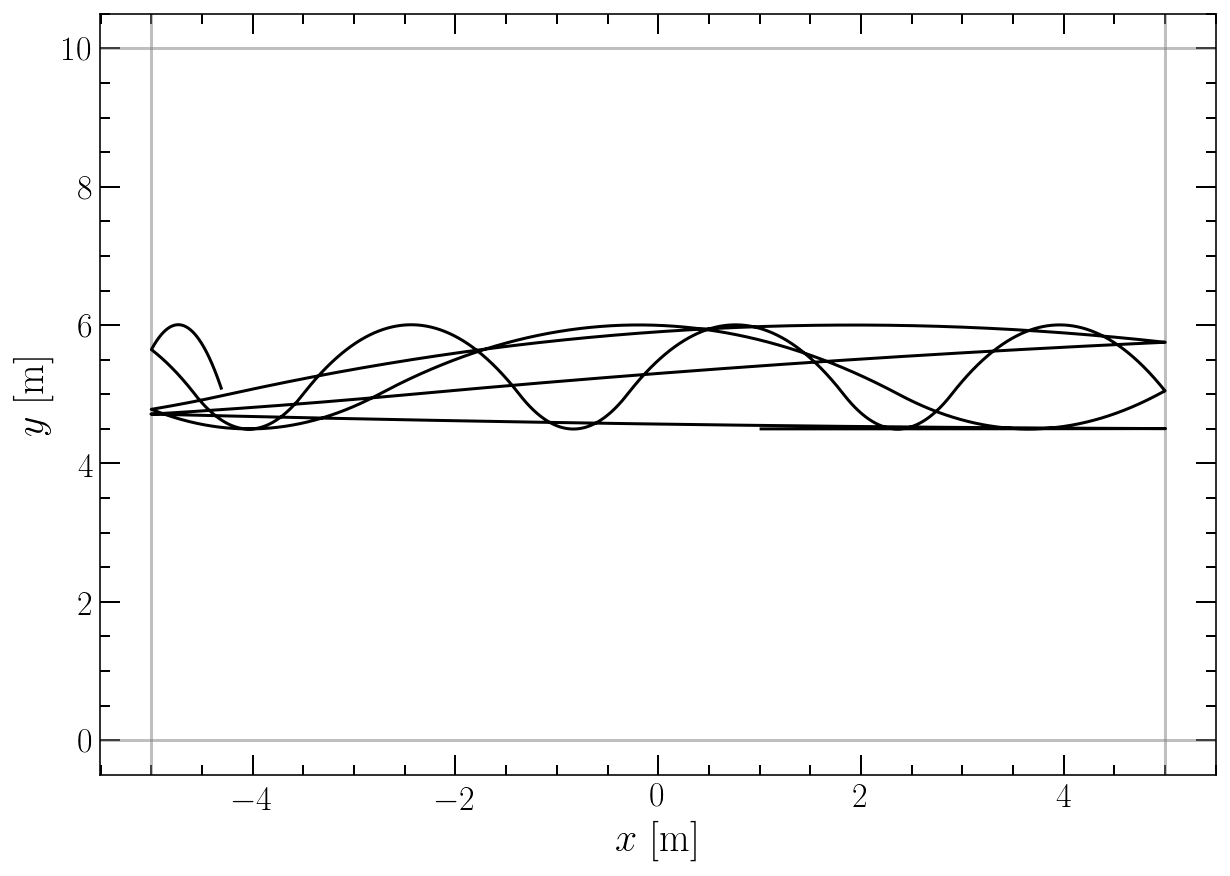

In [9]:
fig, ax = setup_plot(xBounds=True, yBounds=True)
ax.plot(pos[:, 0], pos[:, 1], 'k')

ax.set_xlabel('$x$ [m]', fontsize=20)
ax.set_ylabel('$y$ [m]', fontsize=20)

plt.show()

In [10]:
make_animation(pos, 'BallBouncing.mp4', plt, AutoMinorLocator, step=500)

100%|██████████| 600/600 [02:55<00:00,  3.43it/s]


In [10]:
import io
import base64
from IPython.display import HTML
import os

if not os.path.exists('BallBouncing.mp4'):
    raise IOError('ERROR! Animation has not been generated to the local directory yet!')
video = io.open('BallBouncing.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Looking at just the x position vs time we see linear sections connected with discontinuities at the bounds as we would expect to see given there are no forces acting on the ballon in the x direction.

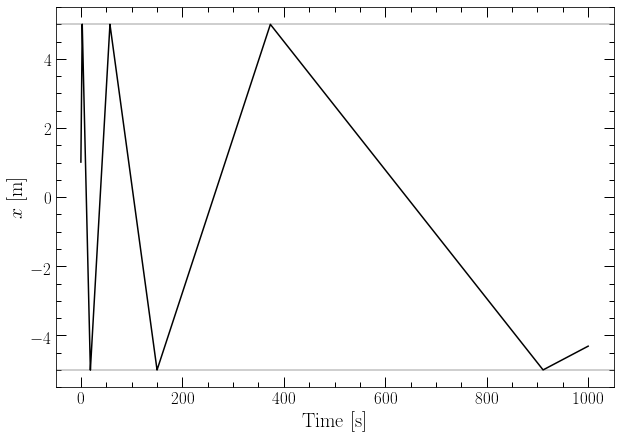

In [240]:
fig, ax = setup_plot(yBounds=True, yBV=[-5, 5])
ax.plot(time_vals, pos[:, 0], 'k')

ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel('$x$ [m]', fontsize=20)

plt.show()

We equally see what we might expect to see in the y direction, the balloon osscillating around the pressure boundary

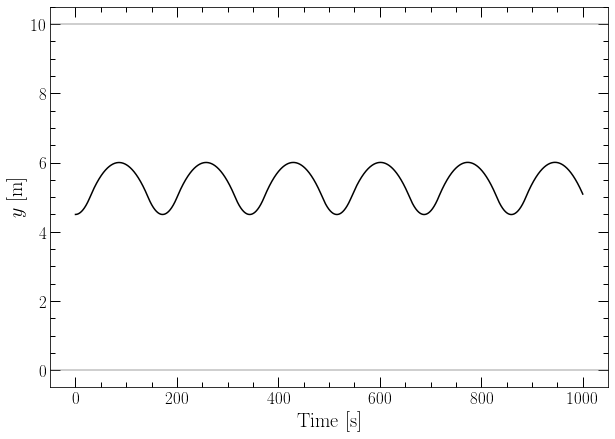

In [239]:
fig, ax = setup_plot(yBounds=True)
ax.plot(time_vals, pos[:, 1], 'k')


ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel('$y$ [m]', fontsize=20)

plt.show()

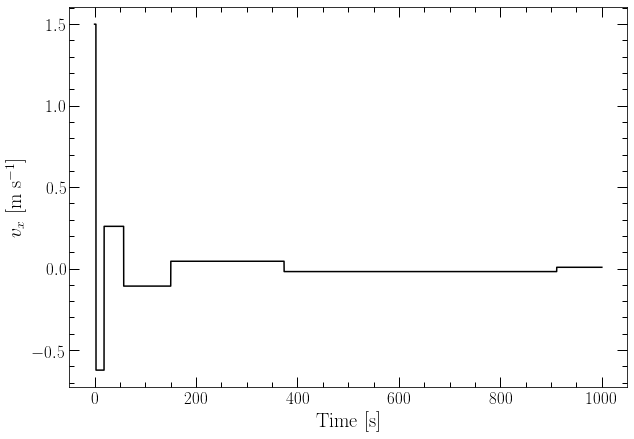

In [238]:
fig, ax = setup_plot()
ax.plot(time_vals, vel[:, 0], 'k')

ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel(r'$v_{x}$ [m s$^{-1}$]', fontsize=20)

plt.show()

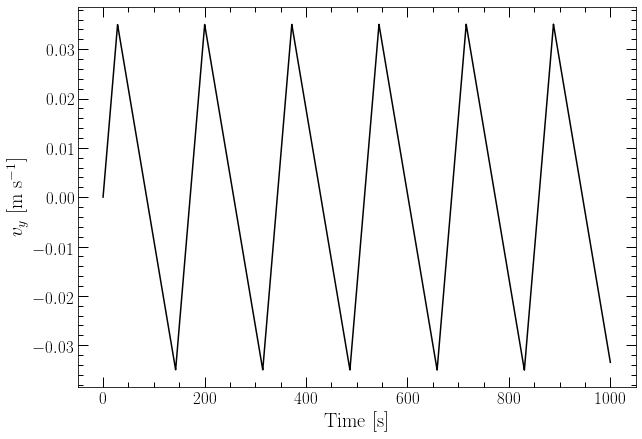

In [237]:
fig, ax = setup_plot()
ax.plot(time_vals, vel[:, 1], 'k')

ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel(r'$v_{y}$ [m s$^{-1}$]', fontsize=20)

plt.show()

<h3>Wind & 3 Dimensions</h3>

The model I have presented so far is relatively boring in all but the y directions. It is possible to plot all three spacial dimensions here; however, given there are no forces in either the x or z directions, that does not hold much interest beyond the 2D situations I have presented here. Below I present an updated model containing an extra "wind" force in both the x and z axis. It should be noted that this is a contrived force; however, because of the implimentation, may model a somewhat accurate situation.

This more complex model also describes the density based on a function.

In [99]:
def bouyModel_wind(I, t, args):
    #  0  1  2  3   4   5
    # [x, y, z, vx, vy, vz]
    dIdt = np.zeros(6)
    dIdt[0] = I[3]
    dIdt[1] = I[4]
    dIdt[2] = I[5]
    
    dIdt[3] = args['wind'][0](I, t)
                # Weight         # Boyant Force                  # Wind Force
    dIdt[4] = (-args['m']*g) + g*args['V']*(args['rho_air']) + args['wind'][1](I, t)
    dIdt[5] = args['wind'][2](I, t)
    return dIdt

In [103]:
class wordIntegrator_wind:
    def __init__(self, confiner, obj, model, method=intgs.rk4,
                 density_func=lambda y, ty: 1.18, wind_0=lambda x, t: 0, 
                 wind_1 = lambda y, t: 0, wind_2=lambda z, t: 0):
        self.object = obj
        self.method = method
        self.model = model
        self.confiner = confiner
        self.clock = 0
        self.step = 0   
        self.get_rho = density_func
        self.wind = (wind_0, wind_1, wind_2)
        
    def get_args(self):
        args = dict()
        args['m'] = self.object.mass
        args['V'] = self.object.volume
        args['a1'] = self.object.a1
        args['a2'] = self.object.a2
        args['a3'] = self.object.a3
        args['rho_air'] = self.get_rho(self.object.pos[1], self.confiner.bounds[1][1])
        args['wind'] = self.wind
        return args

    def timeEvolve(self, dt):
        cx = self.confiner.check_x(self.object.pos[0])
        cy = self.confiner.check_y(self.object.pos[1])
        cz = self.confiner.check_z(self.object.pos[2])
        if cx:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(0)
        if cy:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(1)
        if cz:
            if self.object.ppos is not None:
                self.object.pos = self.object.ppos
            self.object.reflect(2)
            
        cI = list(self.object.pos) + list(self.object.velocity)
        nI = self.method(self.model, cI, self.clock, dt, self.get_args())
        self.object.ppos = self.object.pos
        self.object.pos = nI[:3]
        self.object.velocity = nI[3:]
        
        self.step += 1
        self.clock += dt

I define both a density function
$$
    \rho_{air}(y) = 5\sin(\ln(y^{5}))
$$
and a function describing wind in the x-direction
$$
    F_{w,x}(x, t) = \frac{0.01\sin(x)}{0.005961t+0.01}
$$
These are then passed into the new word Integrator. The effects of the wind pushing the balloon to one side are clear.

In [226]:
def density(y, ty):
    return 5*np.sin(np.log(y**5))

In [241]:
def xwind(I, t):
    return 0.01*np.sin(I[0])/(0.005960*t+0.01)

In [242]:
balloon = balloonObj(0.31, v0=[1.5, 0, 0], r0=[1, 4.5, 1], rho=1)
confiner = confinment([[-5, 5], [0, 10], [-5, 5]])
world = wordIntegrator_wind(confiner, balloon, bouyModel_wind, density_func=density, wind_0=xwind)
pos = list()
vel = list()
dt = 0.01
time_vals = np.arange(0, 1000, dt)
for t in time_vals:
    world.timeEvolve(dt)
    pos.append(world.object.pos)
    vel.append(world.object.velocity)
pos = np.array(pos)
vel = np.array(vel)

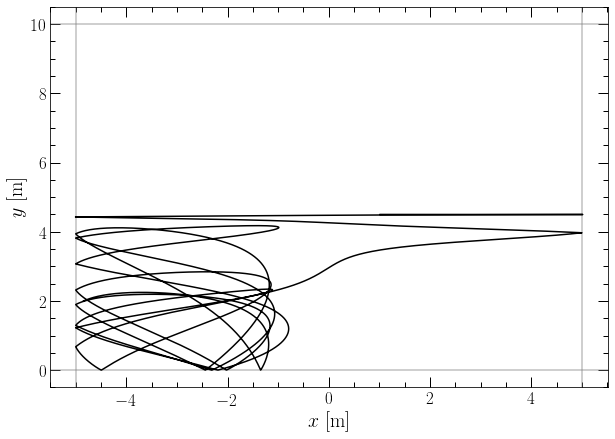

In [243]:
fig, ax = setup_plot(xBounds=True, yBounds=True)
ax.plot(pos[:, 0], pos[:, 1], 'k')

ax.set_xlabel('$x$ [m]', fontsize=20)
ax.set_ylabel('$y$ [m]', fontsize=20)

plt.show()

Finally we will look at 3D. I define the same initial condtitions for integration as above, except I also give the balloon an initial z velocity of 
$$
    v_{z} = -1 \text{ m s}^{-1}
$$
I then plot this in 3D below. If one changes the z velocity so that it approaches 0 it is clear how the motion collapses into one plane

In [230]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [231]:
balloon = balloonObj(0.31, v0=[1.5, 0, -1], r0=[1, 4.5, 1], rho=1)
confiner = confinment([[-5, 5], [0, 10], [-5, 5]])
world = wordIntegrator_wind(confiner, balloon, bouyModel_wind, density_func=density, wind_0=xwind)
pos = list()
vel = list()
dt = 0.1
time_vals = np.arange(0, 1000, dt)
for t in time_vals:
    world.timeEvolve(dt)
    pos.append(world.object.pos)
    vel.append(world.object.velocity)
pos = np.array(pos)
vel = np.array(vel)

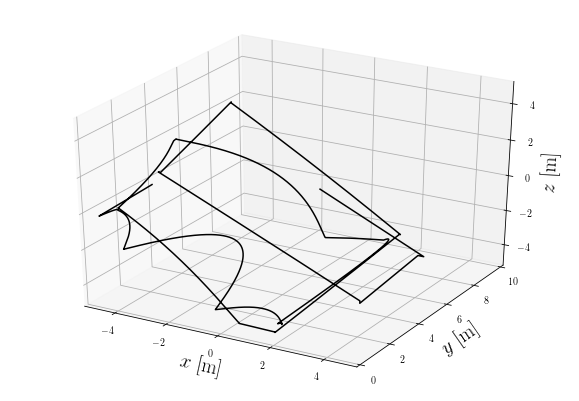

In [232]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], 'k')

ax.set_zlim(-5, 5)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)

ax.set_xlabel('$x$ [m]', fontsize=20)
ax.set_ylabel('$y$ [m]', fontsize=20)
ax.set_zlabel('$z$ [m]', fontsize=20)

plt.show()